In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.metrics import AUC

2024-05-15 20:12:15.079538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 20:12:15.079670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 20:12:15.221404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
IMG_SIZE = 512
BATCH_SIZE = 8
IMG_CHANNELS = 3


In [7]:
import shutil
import os

# Source and destination paths
source_path = "/kaggle/input/mias-mammography/all-mias/"
destination_path = "/kaggle/working/all-mias0/"

# Create the destination folder if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Get a list of all files in the source folder
files = os.listdir(source_path)

# Copy each file from the source folder to the destination folder
for file in files:
    source_file_path = os.path.join(source_path, file)
    destination_file_path = os.path.join(destination_path, file)
    shutil.copy2(source_file_path, destination_file_path)


In [8]:
def convert_pgm_to_jpg(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".pgm"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace(".pgm", ".jpg"))

            # Convert PGM to JPG
            with open(input_path, 'rb') as f:
                # Read the header
                magic_number = f.readline().decode().strip()
                width, height = map(int, f.readline().decode().split())
                max_val = int(f.readline().decode())

                # Check if it's a valid PGM file
                if magic_number != 'P5':
                    print("Error: Not a valid PGM file")
                    continue

                # Read the pixel data
                pixel_data = f.read()

            # Create a grayscale mode image using Pillow
            img = Image.frombytes('L', (width, height), pixel_data)

            # Save the image as a JPEG file
            img.save(output_path, format='JPEG')

In [9]:
source_path = "/kaggle/working/all-mias0"
jpg_path = "/kaggle/working/all-mias"
if not os.path.exists(jpg_path):
    os.makedirs(jpg_path)
convert_pgm_to_jpg(source_path, jpg_path)

In [10]:
data = pd.read_csv('/kaggle/input/mias-mammography/Info.txt', sep=" ", header=None)
data.columns = ["REFNUM", "BG", "CLASS", "SEVERITY", "X", "Y", "RADIUS", "Naveed" ]

del data['Naveed']

data = data.drop(data.index[0])
data['SEVERITY'] = data['SEVERITY'].fillna('N')
data = data.fillna(0)
data1 = data['BG']

for i in data.index:
    data.loc[i, 'REFNUM'] = '/kaggle/working/all-mias/' + data.loc[i, 'REFNUM'] +'.jpg'
    data.loc[i, 'X'] = int((int(data.loc[i, 'X']))*(IMG_SIZE/1024))
    if data.loc[i, 'Y'] != 0:
        data.loc[i, 'Y'] = int(IMG_SIZE - (int(data.loc[i, 'Y']) *(IMG_SIZE/1024)))
    data.loc[i, 'RADIUS'] = int((int(data.loc[i, 'RADIUS']))*(IMG_SIZE/1024))


In [11]:
data_shape = np.shape(data)
if data_shape[1] > 6:
    del data['BG']
    del data['CLASS']
print(data)

                                  REFNUM SEVERITY    X    Y RADIUS
1    /kaggle/working/all-mias/mdb001.jpg        B  267  299     98
2    /kaggle/working/all-mias/mdb002.jpg        B  261  372     34
3    /kaggle/working/all-mias/mdb003.jpg        N    0    0      0
4    /kaggle/working/all-mias/mdb004.jpg        N    0    0      0
5    /kaggle/working/all-mias/mdb005.jpg        B  238  445     15
..                                   ...      ...  ...  ...    ...
326  /kaggle/working/all-mias/mdb318.jpg        N    0    0      0
327  /kaggle/working/all-mias/mdb319.jpg        N    0    0      0
328  /kaggle/working/all-mias/mdb320.jpg        N    0    0      0
329  /kaggle/working/all-mias/mdb321.jpg        N    0    0      0
330  /kaggle/working/all-mias/mdb322.jpg        N    0    0      0

[330 rows x 5 columns]


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def square_img(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Get image dimensions
    height, width = image.shape

    # Determine the size of the square image
    max_dim = max(height, width)
    
    # Create a black square image with dimensions equal to the maximum dimension
    square_image = np.zeros((max_dim, max_dim), dtype=np.uint8)

    # Calculate the position to paste the original image in the square image
    x_offset = (max_dim - width) // 2
    y_offset = (max_dim - height) // 2

    # Paste the original image into the square image
    square_image[y_offset:y_offset+height, x_offset:x_offset+width] = image
    image_shape = square_image.shape
    
    
    return square_image, image_shape

def process_image(image_path):

    # Threshold the image to obtain binary image
    square_image, image_shape = square_img(image_path)
    
    #square_image = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(square_image, 240, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x, y, radius = 0, 0, 0  # Default values
    
    # Iterate through the contours
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        
        # Draw the circle
        x = int(x)
        y = int(y)
        radius = int(radius)
   
    return x,y,radius

In [13]:
import os
import cv2
import random

def copy_and_process_images(source_directory, destination_path, Severity):
    """
    Copies images from source directory to destination directory based on specified conditions.
    
    Args:
    - source_directory (str): Path to the source directory containing images.
    - destination_path (str): Path to the destination directory where images will be copied.
    
    Returns:
    - flipped_images (list): List of dictionaries containing information about copied images.
    """
    options = [1, 2]
    
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)
    
    
    
    flipped_images = []
    
    # Iterate through each folder in the source directory
    for root, dirs, files in os.walk(source_directory):
        
        if source_directory[-6:] == "Normal":
            chosen_option = random.choice(options)
            if chosen_option == 1:
                substring3 = substring1 = 'LEFT_MLO.jpg'
            else:
                substring3 = substring1 = 'RIGHT_MLO.jpg'
        else:
            # Define the substrings you are looking for in the file names
            substring1 = 'LEFT_CC_Mask.jpg'
            substring2 = 'RIGHT_CC_Mask.jpg'
            substring3 = 'LEFT_CC.jpg'
            substring4 = 'RIGHT_CC.jpg'
            
            
            
        # Check if the folder contains a file with substring1
        if any(substring1 in file for file in files):
            if source_directory[-6:] == "Normal":
                X = Y = R = 0
            else:
                file_with_substring1 = next(os.path.join(root, file) for file in files if substring1 in file)
                X, Y, R = process_image(file_with_substring1)  # Assuming you have a function named process_image
            # Find the file with substring3 and copy it
            for file in files:
                if substring3 in file:
                    # Create the source file path
                    source_file_path = os.path.join(root, file)
                    # Process the image and get the processed image
                    processed_image, image_shape = square_img(source_file_path)  # Assuming you have a function named square_img
                    # Create the destination file path
                    destination_file_path = os.path.join(destination_path, file)
                    # Save the processed image
                    cv2.imwrite(destination_file_path, processed_image)
                    flipped_images.append({
                        'REFNUM': destination_file_path,
                        'SEVERITY': Severity,
                        'X': X,
                        'Y': Y,
                        'RADIUS': R,
                        'Image Shape': image_shape[0]
                    })
#                     print(f"File '{file}' copied successfully.")
        
        # Check if the folder contains a file with substring2
        elif any(substring2 in file for file in files):
            if source_directory[-6:] == "Normal":
                X = Y = R = 0
            else:
                file_with_substring2 = next(os.path.join(root, file) for file in files if substring2 in file)
                X, Y, R = process_image(file_with_substring2)  # Assuming you have a function named process_image
            # Find the file with substring4 and copy it
            for file in files:
                if substring4 in file:
                    # Create the source file path
                    source_file_path = os.path.join(root, file)
                    # Process the image and get the processed image
                    processed_image, image_shape = square_img(source_file_path)  # Assuming you have a function named square_img
                    # Create the destination file path
                    destination_file_path = os.path.join(destination_path, file)
                    # Save the processed image
                    cv2.imwrite(destination_file_path, processed_image)
                    flipped_images.append({
                        'REFNUM': destination_file_path,
                        'SEVERITY': Severity,
                        'X': X,
                        'Y': Y,
                        'RADIUS': R,
                        'Image Shape': image_shape[0]
                    })
#                     print(f"File '{file}' copied successfully.")
    
    print("Files copied according to the specified conditions.")
    return flipped_images


In [14]:
import pandas as pd

source_directory_C = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Cancer'
destination_path_C = "/kaggle/working/cancer/"

source_directory_N = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Normal'
destination_path_N = "/kaggle/working/normal/"

images_DFC = pd.DataFrame(copy_and_process_images(source_directory_C, destination_path_C, "M"))
images_DFN = pd.DataFrame(copy_and_process_images(source_directory_N, destination_path_N, "N"))

Files copied according to the specified conditions.
Files copied according to the specified conditions.


In [15]:
print(len(images_DFC))
print(len(images_DFN))

644
602


In [16]:
data2 = pd.concat([images_DFC, images_DFN])
data2 = data2.sample(frac=1).reset_index(drop = True)
data2

,REFNUM,SEVERITY,X,Y,RADIUS,Image Shape
0,/kaggle/working/normal/A_0608_1.LEFT_MLO.jpg,N,0,0,0,3211
1,/kaggle/working/cancer/A_1873_1.LEFT_CC.jpg,M,1546,1569,49,2746
2,/kaggle/working/cancer/B_3108_1.LEFT_CC.jpg,M,1014,1876,105,2412
3,/kaggle/working/cancer/C_0342_1.RIGHT_CC.jpg,M,2116,1284,593,2884
4,/kaggle/working/cancer/D_4053_1.LEFT_CC.jpg,M,1381,1219,150,2633
...,...,...,...,...,...,...
1241,/kaggle/working/cancer/A_1574_1.RIGHT_CC.jpg,M,967,1481,157,2746
1242,/kaggle/working/cancer/C_0095_1.RIGHT_CC.jpg,M,2186,514,211,2944
1243,/kaggle/working/cancer/C_0127_1.RIGHT_CC.jpg,M,1672,854,134,2404
1244,/kaggle/working/normal/A_0526_1.RIGHT_MLO.jpg,N,0,0,0,2746


In [17]:
def resize_image(df, new_size = (IMG_SIZE,IMG_SIZE)):
    for index, row in df.iterrows():
        image_path = row['REFNUM']
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, new_size)
        cv2.imwrite(image_path, resized_image)
resize_image(data2)
data2

,REFNUM,SEVERITY,X,Y,RADIUS,Image Shape
0,/kaggle/working/normal/A_0608_1.LEFT_MLO.jpg,N,0,0,0,3211
1,/kaggle/working/cancer/A_1873_1.LEFT_CC.jpg,M,1546,1569,49,2746
2,/kaggle/working/cancer/B_3108_1.LEFT_CC.jpg,M,1014,1876,105,2412
3,/kaggle/working/cancer/C_0342_1.RIGHT_CC.jpg,M,2116,1284,593,2884
4,/kaggle/working/cancer/D_4053_1.LEFT_CC.jpg,M,1381,1219,150,2633
...,...,...,...,...,...,...
1241,/kaggle/working/cancer/A_1574_1.RIGHT_CC.jpg,M,967,1481,157,2746
1242,/kaggle/working/cancer/C_0095_1.RIGHT_CC.jpg,M,2186,514,211,2944
1243,/kaggle/working/cancer/C_0127_1.RIGHT_CC.jpg,M,1672,854,134,2404
1244,/kaggle/working/normal/A_0526_1.RIGHT_MLO.jpg,N,0,0,0,2746


In [18]:
scaling_factor = IMG_SIZE / data2['Image Shape']
columns_to_scale = ['X', 'Y', 'RADIUS']
data2[columns_to_scale] = data2[columns_to_scale].multiply(scaling_factor, axis=0)

In [19]:
del data2['Image Shape']
data2

,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/normal/A_0608_1.LEFT_MLO.jpg,N,0.000000,0.000000,0.000000
1,/kaggle/working/cancer/A_1873_1.LEFT_CC.jpg,M,288.256373,292.544792,9.136198
2,/kaggle/working/cancer/B_3108_1.LEFT_CC.jpg,M,215.243781,398.222222,22.288557
3,/kaggle/working/cancer/C_0342_1.RIGHT_CC.jpg,M,375.656033,227.950069,105.276006
4,/kaggle/working/cancer/D_4053_1.LEFT_CC.jpg,M,268.542347,237.040638,29.168249
...,...,...,...,...,...
1241,/kaggle/working/cancer/A_1574_1.RIGHT_CC.jpg,M,180.300073,276.136926,29.273125
1242,/kaggle/working/cancer/C_0095_1.RIGHT_CC.jpg,M,380.173913,89.391304,36.695652
1243,/kaggle/working/cancer/C_0127_1.RIGHT_CC.jpg,M,356.099834,181.883527,28.539101
1244,/kaggle/working/normal/A_0526_1.RIGHT_MLO.jpg,N,0.000000,0.000000,0.000000


In [20]:
main_data = pd.concat([data, data2])

In [21]:
from sklearn.utils import shuffle
# Shuffle the rows
main_data = shuffle(main_data).reset_index(drop=True)
columns_to_convert = ['X', 'Y', 'RADIUS'] 
main_data[columns_to_convert] = main_data[columns_to_convert].astype(int)
main_data


,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/normal/A_0597_1.LEFT_MLO.jpg,N,0,0,0
1,/kaggle/working/cancer/A_1486_1.RIGHT_CC.jpg,M,247,272,41
2,/kaggle/working/cancer/C_0065_1.LEFT_CC.jpg,M,136,139,26
3,/kaggle/working/all-mias/mdb003.jpg,N,0,0,0
4,/kaggle/working/cancer/A_1618_1.RIGHT_CC.jpg,M,141,314,18
...,...,...,...,...,...
1571,/kaggle/working/normal/A_0111_1.LEFT_MLO.jpg,N,0,0,0
1572,/kaggle/working/cancer/D_4127_1.RIGHT_CC.jpg,M,328,330,43
1573,/kaggle/working/cancer/C_0195_1.RIGHT_CC.jpg,M,376,182,66
1574,/kaggle/working/cancer/D_4115_1.LEFT_CC.jpg,M,151,136,34


In [22]:
DFM = main_data
DFN = main_data

condition = (main_data['SEVERITY'] == "B") | (main_data['SEVERITY'] == "M")
DFN = main_data[~condition].reset_index(drop=True)

condition = (main_data['SEVERITY'] == "B") | (main_data['SEVERITY'] == "N")
DFM = main_data[~condition].reset_index(drop=True)

print(len(DFM))
print(len(DFN))


698
809


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_with_circles_and_labels(dataframe, rows=5, cols=3, image_size=512):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    for i in range(rows):
        for j in range(cols):
            index = np.random.randint(0, len(dataframe))  # Randomly select an index
            img_path = dataframe.iloc[index, 0]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (image_size, image_size))
            x = int(dataframe.iloc[index, 2])
            y = int(dataframe.iloc[index, 3])
            radius = int(dataframe.iloc[index, 4])
            cv2.circle(img, (x, y), radius, (255, 0, 0), 4)  # Draw circle
            axes[i, j].imshow(img, cmap='gray')  # Plot in grayscale
            axes[i, j].axis('off')
            label = dataframe.iloc[index, 1]
            axes[i, j].set_title(f"Severity: {label}", fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [24]:
DFM = DFM[DFM['RADIUS'] >= 10]
DFN = DFN.sample(n=650, random_state=42)
print(len(DFM))
print(len(DFN))

649
650


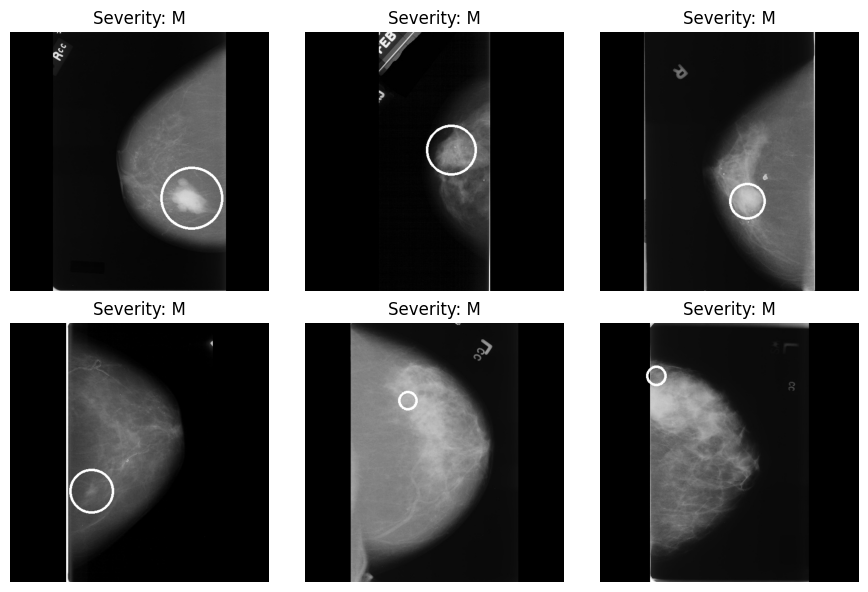

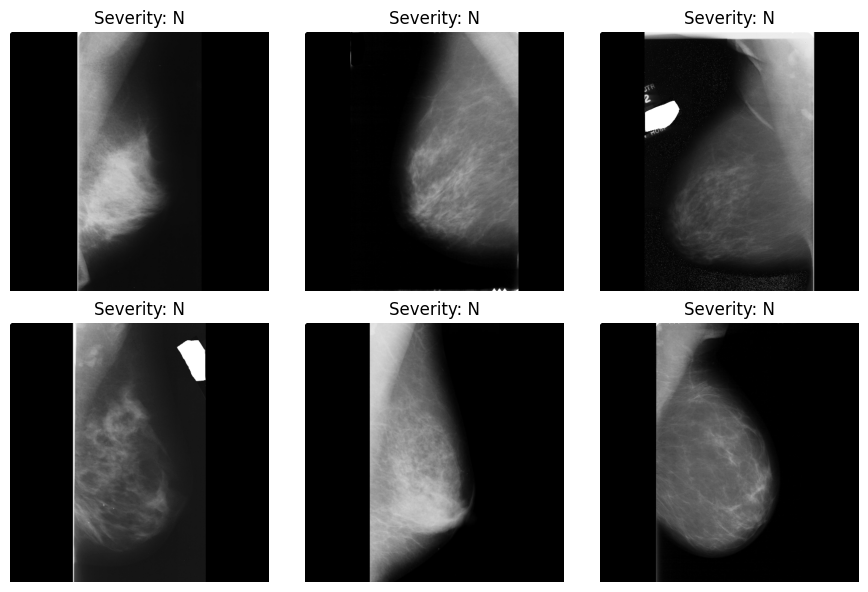

In [25]:
plot_images_with_circles_and_labels(DFM, rows=2, cols=3)
plot_images_with_circles_and_labels(DFN, rows=2, cols=3)

In [26]:
test_split_M = 195
test_split_N = 195
# Shuffle the rows of each DataFrame
DFM_shuffled = shuffle(DFM,random_state=80)
DFN_shuffled = shuffle(DFN,random_state=90)

In [27]:
# Select the first 41 rows from each shuffled DataFrame
dftest = pd.concat( [DFM_shuffled.iloc[:test_split_M], DFN_shuffled.iloc[:test_split_N]], ignore_index=True)
dftest = shuffle(dftest)

# Select the remaining rows (starting from the 42nd row) from each shuffled DataFrame
dftrain = pd.concat([DFM_shuffled.iloc[test_split_M:], DFN_shuffled.iloc[test_split_N:]], ignore_index=True)
dftrain = shuffle(dftrain)
# Check the number of rows in each DataFrame
print("Number of rows in dftest:", len(dftest))
print("Number of rows in dftrain:", len(dftrain))

Number of rows in dftest: 390
Number of rows in dftrain: 909


In [28]:
#dftest['SEVERITY'] = dftest['SEVERITY'].replace({'N':0, 'B': 1, 'M': 2})
#dftrain['SEVERITY'] = dftrain['SEVERITY'].replace({'N':0, 'B': 1, 'M': 2})

dftest = dftest.reset_index(drop=True)
dftrain = dftrain.reset_index(drop=True)

In [29]:
dftrain

,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/cancer/B_3074_1.RIGHT_CC.jpg,M,395,395,15
1,/kaggle/working/normal/D_4546_1.LEFT_MLO.jpg,N,0,0,0
2,/kaggle/working/cancer/A_1577_1.RIGHT_CC.jpg,M,223,210,34
3,/kaggle/working/normal/A_0708_1.LEFT_MLO.jpg,N,0,0,0
4,/kaggle/working/normal/A_0528_1.LEFT_MLO.jpg,N,0,0,0
...,...,...,...,...,...
904,/kaggle/working/normal/A_0497_1.LEFT_MLO.jpg,N,0,0,0
905,/kaggle/working/normal/A_0484_1.LEFT_MLO.jpg,N,0,0,0
906,/kaggle/working/all-mias/mdb162.jpg,N,0,0,0
907,/kaggle/working/normal/A_0343_1.LEFT_MLO.jpg,N,0,0,0


In [30]:
dftest

,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/cancer/B_3513_1.RIGHT_CC.jpg,M,390,118,30
1,/kaggle/working/all-mias/mdb221.jpg,N,0,0,0
2,/kaggle/working/cancer/A_1469_1.LEFT_CC.jpg,M,245,351,19
3,/kaggle/working/cancer/A_1589_1.LEFT_CC.jpg,M,359,140,28
4,/kaggle/working/all-mias/mdb229.jpg,N,0,0,0
...,...,...,...,...,...
385,/kaggle/working/normal/A_0365_1.RIGHT_MLO.jpg,N,0,0,0
386,/kaggle/working/cancer/C_0137_1.LEFT_CC.jpg,M,217,268,67
387,/kaggle/working/cancer/D_4049_1.RIGHT_CC.jpg,M,369,128,37
388,/kaggle/working/cancer/C_0059_1.LEFT_CC.jpg,M,268,234,44


In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dftrain['severity_encoded'] = label_encoder.fit_transform(dftrain['SEVERITY'])
dftest['severity_encoded'] = label_encoder.fit_transform(dftest['SEVERITY'])
dftrain

,REFNUM,SEVERITY,X,Y,RADIUS,severity_encoded
0,/kaggle/working/cancer/B_3074_1.RIGHT_CC.jpg,M,395,395,15,0
1,/kaggle/working/normal/D_4546_1.LEFT_MLO.jpg,N,0,0,0,1
2,/kaggle/working/cancer/A_1577_1.RIGHT_CC.jpg,M,223,210,34,0
3,/kaggle/working/normal/A_0708_1.LEFT_MLO.jpg,N,0,0,0,1
4,/kaggle/working/normal/A_0528_1.LEFT_MLO.jpg,N,0,0,0,1
...,...,...,...,...,...,...
904,/kaggle/working/normal/A_0497_1.LEFT_MLO.jpg,N,0,0,0,1
905,/kaggle/working/normal/A_0484_1.LEFT_MLO.jpg,N,0,0,0,1
906,/kaggle/working/all-mias/mdb162.jpg,N,0,0,0,1
907,/kaggle/working/normal/A_0343_1.LEFT_MLO.jpg,N,0,0,0,1


In [32]:
max_x1 = np.max(dftest['X'])
max_x2 = np.max(dftrain['X'])
max_y1 = np.max(dftrain['Y'])
max_y2 = np.max(dftest['Y'])
max_radius1 = np.max(dftest['RADIUS'])
max_radius2 = np.max(dftest['RADIUS'])
numbers = tf.constant([max_x1, max_y1, max_radius1, max_radius2], dtype=tf.float32)
max_scaler = tf.reduce_max(numbers)
max_scaler = np.array(max_scaler)

In [33]:
def preprocess_image(image_path, label, x, y, radius):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    x = tf.cast(x, tf.float32) / max_scaler
    y = tf.cast(y, tf.float32) / max_scaler
    radius = tf.cast(radius, tf.float32) / max_scaler
    
    # Return image and labels
    return img, {'classification': tf.one_hot(label, depth = 1),
                 'localization': tf.convert_to_tensor([x, y, radius], dtype=tf.float32)}


In [34]:
# Convert columns to numeric data types
dftrain['X'] = pd.to_numeric(dftrain['X'], errors='coerce')
dftrain['Y'] = pd.to_numeric(dftrain['Y'], errors='coerce')
dftrain['RADIUS'] = pd.to_numeric(dftrain['RADIUS'], errors='coerce')

# Drop rows with NaN values if necessary
dftrain.dropna(subset=['X', 'Y', 'RADIUS'], inplace=True)


dftest['X'] = pd.to_numeric(dftest['X'], errors='coerce')
dftest['Y'] = pd.to_numeric(dftest['Y'], errors='coerce')
dftest['RADIUS'] = pd.to_numeric(dftest['RADIUS'], errors='coerce')

# Drop rows with NaN values if necessary
dftest.dropna(subset=['X', 'Y', 'RADIUS'], inplace=True)

In [35]:
# Create TensorFlow Dataset with image paths and other relevant information
train_dataset = tf.data.Dataset.from_tensor_slices((dftrain['REFNUM'].values,
                                                    dftrain['severity_encoded'].values,
                                                    dftrain['X'].values,
                                                    dftrain['Y'].values,
                                                    dftrain['RADIUS'].values))


# Create TensorFlow Dataset for test data
test_dataset = tf.data.Dataset.from_tensor_slices((dftest['REFNUM'].values,
                                                   dftest['severity_encoded'].values,
                                                   dftest['X'].values,
                                                   dftest['Y'].values,
                                                   dftest['RADIUS'].values))


In [36]:
# Map the preprocessing function to load and preprocess each image
training_dataset = train_dataset.map(lambda image_path, label, x, y, radius:
                                  preprocess_image(image_path, label, x, y, radius),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Map the preprocessing function to load and preprocess each image
test_dataset = test_dataset.map(lambda image_path, label, x, y, radius:
                                preprocess_image(image_path, label, x, y, radius),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [37]:
train_dataset = training_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [38]:
import matplotlib.pyplot as plt

# Define a function to visualize the dataset
def visualize_dataset(dataset, num_samples=1):
    # Iterate through the dataset and display images with labels
    for image_batch, labels_batch in dataset.take(num_samples):
        for i in range(len(image_batch)):
            img = image_batch[i].numpy()  # Convert TensorFlow tensor to NumPy array
            classification_label = labels_batch['classification'][i].numpy()
            localization_label = labels_batch['localization'][i].numpy()
            
            # Display image
            plt.imshow(img)
            print(np.shape(img))
            plt.axis('off')
            plt.show()
            
            # Print labels
            print("Classification Label:", classification_label)
            print("Localization Label:", localization_label)
            break
        break


(512, 512, 1)


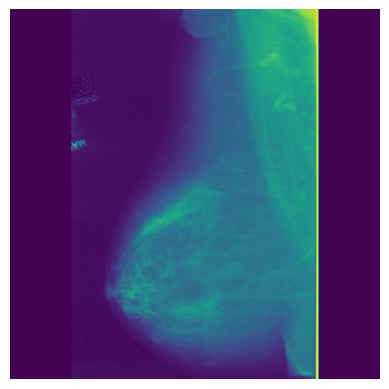

Classification Label: [0.]
Localization Label: [0. 0. 0.]


In [39]:
# Visualize the first few samples from the dataset
visualize_dataset(train_dataset)

(512, 512, 1)


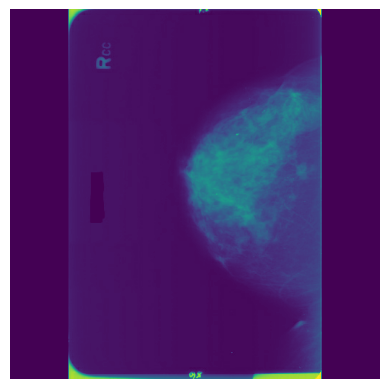

Classification Label: [1.]
Localization Label: [0.9489051  0.28710464 0.0729927 ]


In [40]:
# Visualize the first few samples from the dataset
visualize_dataset(test_dataset)

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, Accuracy
import math
import tensorflow.keras.backend as K


def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )




## Input layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

## Feature Extractor
x = tf.keras.layers.Conv2D(16, activation="relu", kernel_size=3,
                             input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
# x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)  #
x = tf.keras.layers.Dropout(0.3)(x)#

x = tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu")(x)
# x = tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Conv2D(512, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)






## Dense Layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
feature = tf.keras.layers.Dense(64, activation = 'relu')(x)

## Classification head
x = tf.keras.layers.Dense(128, activation = 'relu')(feature)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
classification_output = tf.keras.layers.Dense(1, activation="sigmoid", name="classification")(x)

## Localization Head
x = tf.keras.layers.Dense(128, activation = 'relu')(feature)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
localization_output = tf.keras.layers.Dense(units=3, activation = 'relu', name="localization")(x)


model = tf.keras.Model(inputs=inputs, outputs=[classification_output, localization_output])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={
                  'classification': "binary_crossentropy",
                  'localization':"mse"
              },
              loss_weights={
                  'classification': 1.0,
                  'localization': 1.0
              },
              metrics={'classification': ['accuracy', AUC()],
                       'localization': ['mse', r_squared]})
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 510, 510,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 510, 510,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 255, 255,  │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 255, 255,  │          0 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 253, 253,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 126, 126,  │          0 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 124,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 62, 62,    │          0 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 60, 60,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        256 │ average_pooling2… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30, 30,    │          0 │ batch_normalizat

 Total params: 2,294,500 (8.75 MB)

 Trainable params: 2,292,356 (8.74 MB)

 Non-trainable params: 2,144 (8.38 KB)

In [42]:
num_epochs = 200

# Fit the model with the training data
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=test_dataset,
                    shuffle = True,
                  )

Epoch 1/200


2024-05-15 20:17:40.970571: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.45549, expected 2.6926
2024-05-15 20:17:40.970639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.19187, expected 2.42899
2024-05-15 20:17:40.970648: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.04121, expected 2.27832
2024-05-15 20:17:40.970656: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.3637, expected 2.60082
2024-05-15 20:17:40.970663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.65672, expected 2.89383
2024-05-15 20:17:40.970671: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.34674, expected 3.58385
2024-05-15 20:17:40.970679: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.38785, expected 3.62496
2024-05-15 20:17:40.970686: E external/local_xla/xla/serv

  5/114 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - classification_accuracy: 0.3975 - classification_auc: 0.1680 - localization_mse: 0.1244 - localization_r_squared: -0.3878 - loss: 0.8473  

I0000 00:00:1715804279.063468     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715804279.096127     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - classification_accuracy: 0.5126 - classification_auc: 0.6120 - localization_mse: 0.0864 - localization_r_squared: -121747.7734 - loss: 0.7411

2024-05-15 20:18:11.674383: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520200: 2.56547, expected 1.74189
2024-05-15 20:18:11.674441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520201: 1.88166, expected 1.05808
2024-05-15 20:18:11.674451: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520202: 2.23247, expected 1.40889
2024-05-15 20:18:11.674459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520203: 2.61692, expected 1.79335
2024-05-15 20:18:11.674467: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520204: 2.68856, expected 1.86499
2024-05-15 20:18:11.674475: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520205: 2.89487, expected 2.0713
2024-05-15 20:18:11.674482: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 520206: 2.48264, expected 1.65907
2024-05-15 20:18:11.6

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - classification_accuracy: 0.5134 - classification_auc: 0.6135 - localization_mse: 0.0863 - localization_r_squared: -122020.0391 - loss: 0.7404

W0000 00:00:1715804312.036218     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-15 20:18:32.775980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260100: 3.96542, expected 3.30316
2024-05-15 20:18:32.776046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260101: 4.19441, expected 3.53215
2024-05-15 20:18:32.776061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260102: 3.89545, expected 3.23319
2024-05-15 20:18:32.776079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260103: 3.74718, expected 3.08492
2024-05-15 20:18:32.776091: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260104: 5.50647, expected 4.84421
2024-05-15 20:18:32.776102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 260106: 4.54534, expected 3.88308
2024-05-15 20:18:32.776112: E exter

114/114 ━━━━━━━━━━━━━━━━━━━━ 71s 314ms/step - classification_accuracy: 0.5140 - classification_auc: 0.6150 - localization_mse: 0.0861 - localization_r_squared: -122287.5703 - loss: 0.7398 - val_classification_accuracy: 0.5000 - val_classification_auc: 0.8535 - val_localization_mse: 0.0727 - val_localization_r_squared: 0.0591 - val_loss: 1.0480
Epoch 2/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - classification_accuracy: 0.8456 - classification_auc: 0.9140 - localization_mse: 0.0593 - localization_r_squared: -27804.6094 - loss: 0.4421 - val_classification_accuracy: 0.5000 - val_classification_auc: 0.9037 - val_localization_mse: 0.0653 - val_localization_r_squared: 0.1478 - val_loss: 0.9728
Epoch 3/200
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - classification_accuracy: 0.9158 - classification_auc: 0.9645 - localization_mse: 0.0443 - localization_r_squared: -8729.9336 - loss: 0.2917 - val_classification_accuracy: 0.5077 - val_classification_auc: 0.9214 - val_localization_mse: 0.0778 -

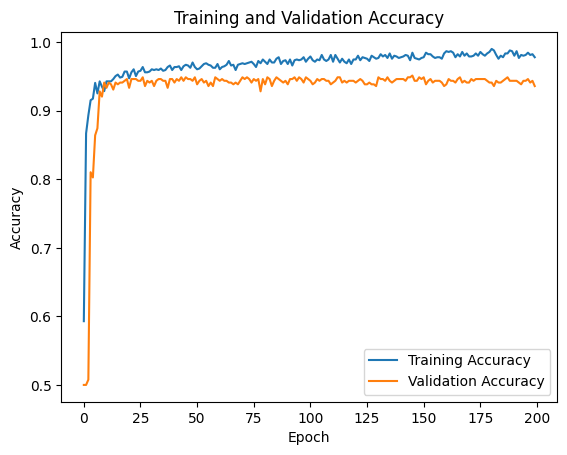

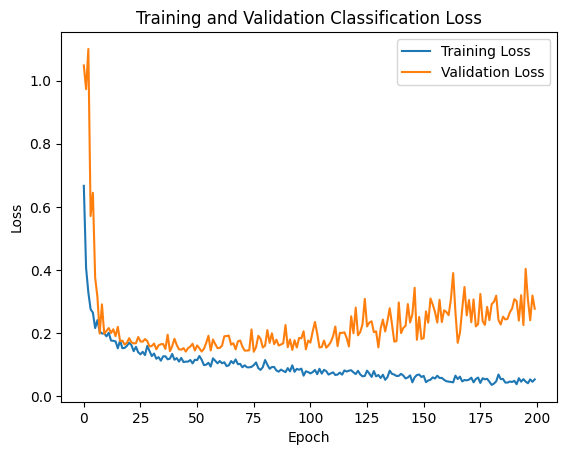

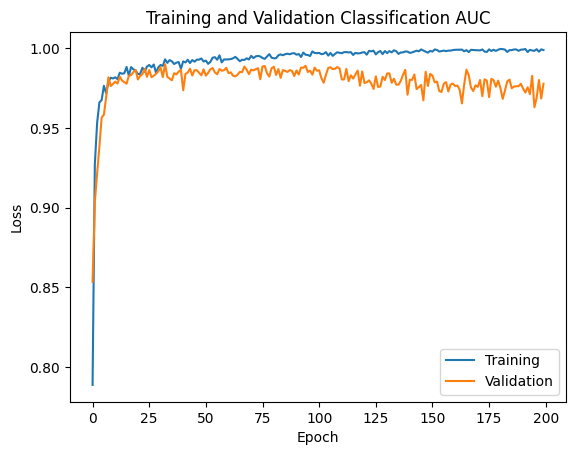

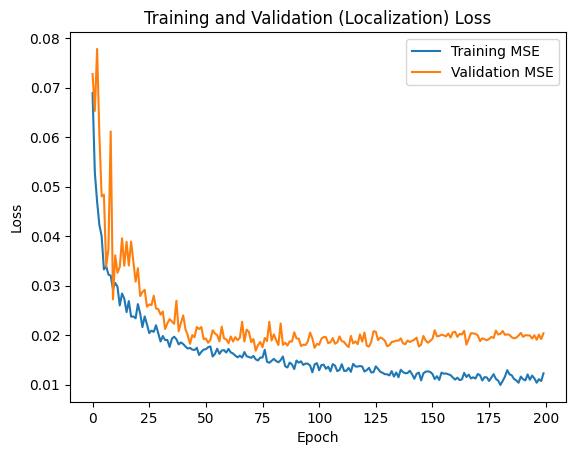

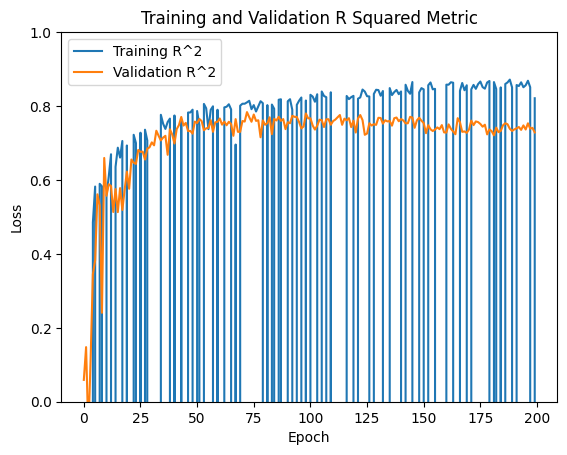

In [43]:

# Plot training and validation accuracy
plt.plot(history.history['classification_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_classification_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation AUC
plt.plot(history.history['classification_auc'], label='Training ')
plt.plot(history.history['val_classification_auc'], label='Validation')
plt.title('Training and Validation Classification AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['localization_mse'], label='Training MSE')
plt.plot(history.history['val_localization_mse'], label='Validation MSE')
plt.title('Training and Validation (Localization) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation r^2
plt.plot(history.history['localization_r_squared'], label='Training R^2')
plt.plot(history.history['val_localization_r_squared'], label='Validation R^2')
plt.title('Training and Validation R Squared Metric')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()


29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

W0000 00:00:1715805235.453576     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


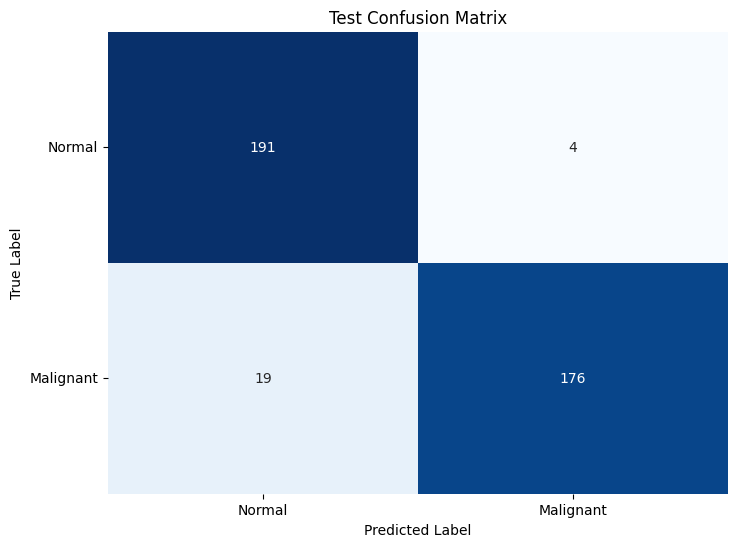

Accuracy: 0.941025641025641
F1 Score: 0.9386666666666666
AUC: 0.9410256410256409
Precision: 0.9777777777777777
Recall: 0.9025641025641026


In [44]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score


# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Extracting classification predictions from the model output
classification_predictions = predictions[0]
classification_predictions = (classification_predictions > .9).astype('int32').flatten()

# Extracting true labels from the test dataset
true_labels = []
for batch, labels_batch in test_dataset:
    for labels in labels_batch['classification']:
        true_labels.append(labels.numpy())
        
true_labels = np.array(true_labels)
    

# Map numeric labels to class names
class_names = {
    0: "Normal",
    1: "Malignant"
}

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, classification_predictions)
# Calculate metrics
accuracy = accuracy_score(true_labels, classification_predictions)
f1 = f1_score(true_labels, classification_predictions)
auc = roc_auc_score(true_labels, classification_predictions)
precision = precision_score(true_labels, classification_predictions)
recall = recall_score(true_labels, classification_predictions)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')

# Set ticks
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(np.arange(len(class_names)) + 0.5, tick_labels)
plt.yticks(np.arange(len(class_names)) + 0.5, tick_labels, rotation=0)

plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC:", auc)
print("Precision:", precision)
print("Recall:", recall)



114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


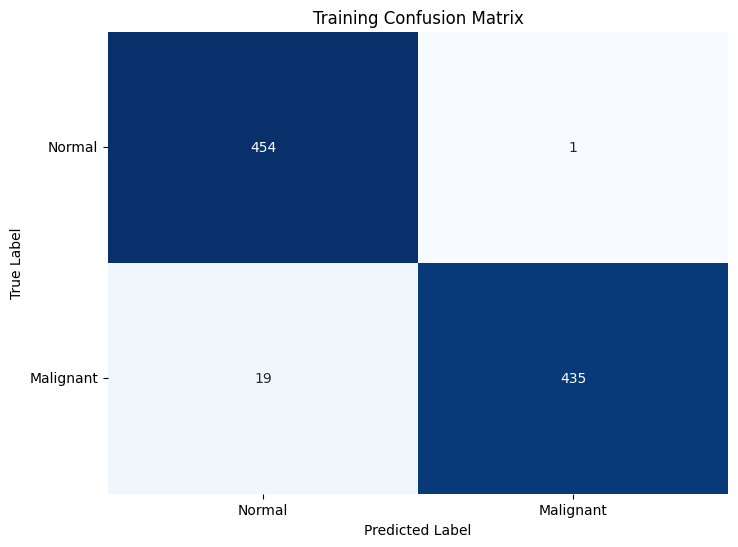

Accuracy: 0.977997799779978
F1 Score: 0.9775280898876404
AUC: 0.9779759887689403
Precision: 0.9977064220183486
Recall: 0.9581497797356828


In [45]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

train_dataset_1 = training_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Make predictions on the test dataset
predictions = model.predict(train_dataset_1)

# Extracting classification predictions from the model output
classification_predictions = predictions[0]
classification_predictions = (classification_predictions > .9).astype('int32').flatten()

# Extracting true labels from the test dataset
true_labels = []
for batch, labels_batch in train_dataset_1:
    for labels in labels_batch['classification']:
        true_labels.append(labels.numpy())
        
true_labels = np.array(true_labels)
    

# Map numeric labels to class names
class_names = {
    0: "Normal",
    1: "Malignant"
}

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, classification_predictions)
# Calculate metrics
accuracy = accuracy_score(true_labels, classification_predictions)
f1 = f1_score(true_labels, classification_predictions)
auc = roc_auc_score(true_labels, classification_predictions)
precision = precision_score(true_labels, classification_predictions)
recall = recall_score(true_labels, classification_predictions)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Confusion Matrix')

# Set ticks
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(np.arange(len(class_names)) + 0.5, tick_labels)
plt.yticks(np.arange(len(class_names)) + 0.5, tick_labels, rotation=0)

plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC:", auc)
print("Precision:", precision)
print("Recall:", recall)



49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


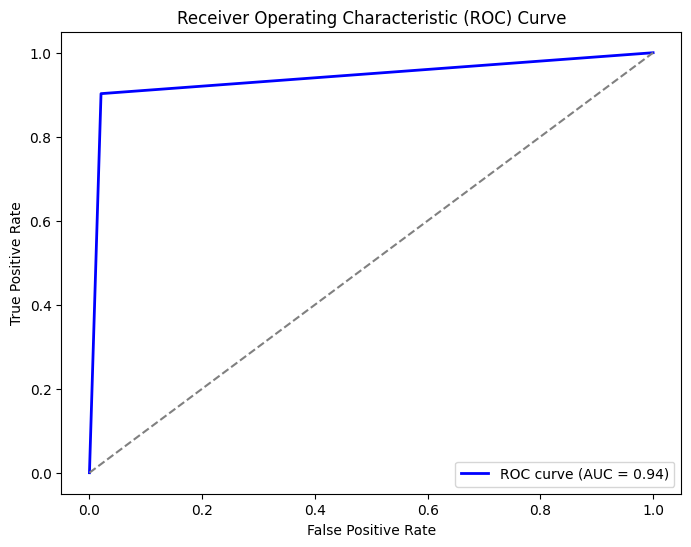

In [55]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Extracting classification predictions from the model output
classification_predictions = predictions[0]
classification_predictions = (classification_predictions > .9).astype('int32').flatten()

# Extracting true labels from the test dataset
true_labels = []
for batch, labels_batch in test_dataset:
    for labels in labels_batch['classification']:
        true_labels.append(labels.numpy())
        
true_labels = np.array(true_labels)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, classification_predictions)

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
